In [2]:
import pandas as pd
from fbprophet import Prophet

In [59]:
df = pd.read_csv('../../data/prophet/example_wp_log_peyton_manning.csv')
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
ds    2905 non-null object
y     2905 non-null float64
dtypes: float64(1), object(1)
memory usage: 45.5+ KB


,ds,y
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871
2904,2016-01-20,8.891374


In [4]:
m = Prophet()
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

그리고 make_future_dataframe() 함수를 이용해 예측값을 넣을 데이터 프레임을 생성합니다. 이때, 인자로 들어가는 periods 값은 향후 몇일 (또는 주,월 등 단위 주기) 을 예측할 것인지를 의미합니다. 아래 코드에서 predict() 함수를 통해 향후 100일의 실적을 예측합니다.

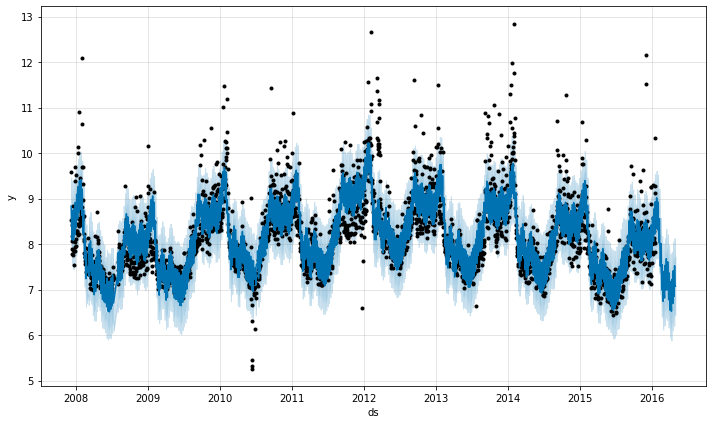

In [10]:
forecast_fig = m.plot(forecast)

파란색 선이 모델이 예측한 값이고, 검정색 점들이 실제 데이터 입니다. 파라미터를 설정해주지 않은 기본값으로도 패턴을 꽤 잘 잡아내고 있죠? 피팅된 모델의 컴포넌트들을 시각화해보면 아래와 같습니다.

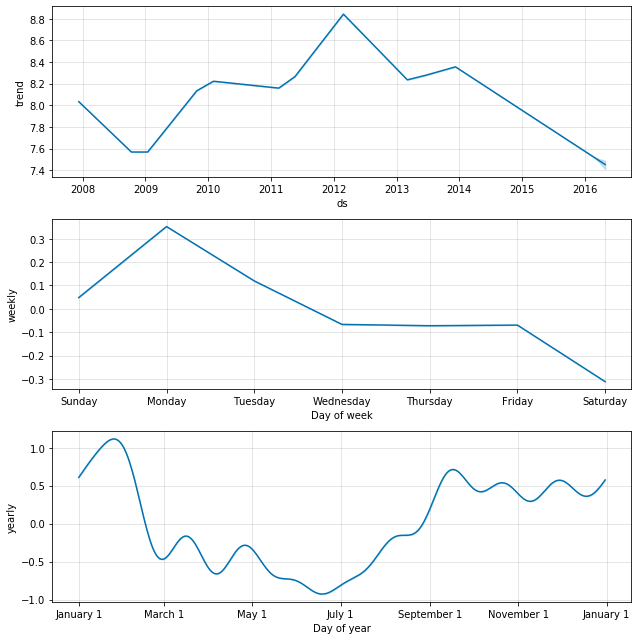

In [11]:
forcast_fig2 = m.plot_components(forecast)

위 결과로 나온 컴포넌트들을 하나하나 해석해봅시다. 

**Trend**
- Trend는 점점 증가하는 추세를 보입니다. 
- 만약 모델이 데이터의 Trend를 잘 잡아내지 못하는 것 같다면, 
- changepoint_prior_scale 파라미터값을 높여주어 changepoint를 더 민감하게 감지하도록 할 수 있습니다. 
- 여기서 changepoint란, Trend가 변화하는 지점을 의미합니다.

**Seasonality**
그 아래 차트는 각각 ‘주 계절성’과 ‘연 계절성’을 의미합니다. 
- 두번째 차트인 weekly 먼저 살펴보면, 
- 월요일에 가장 실적이 높게 나타나는 패턴을 보입니다. 
- yearly 패턴으로는 1~2월에 실적이 급격하게 상승하는 모습을 보이네요. 
- Trend와 마찬가지로 Seasonality또한 seasonality_prior_scale 파라미터로 모델 반영 강도를 조절할 수 있습니다.

# Trend
모델의 Trend를 조절할 수 있는 파라미터는 다음과 같습니다.

|Parameter                  |Description
| :--- | :---
|changepoints               |트렌드 변화시점을 명시한 리스트값
|changepoint_prior_scale	|changepoint (trend) 의 유연성 조절
|n_changepoints          	|changepoint 의 개수
|changepoint_range	        |changepoint 설정 가능 범위. (기본적으로 데이터 중 80% 범위 내에서 changepoint를 설정합니다.)


다음에서 모델의 changepoint 를 시각화해보고, changepoint_prior_scale 값 변경에 따른 Trend 변화를 살펴보겠습니다.

changepoint_prior_scale = 0.05 (default)

다음에서 모델의 changepoint 를 시각화해보고, changepoint_prior_scale 값 변경에 따른 Trend 변화를 살펴보겠습니다.
```python
changepoint_prior_scale = 0.05 (default)
```

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


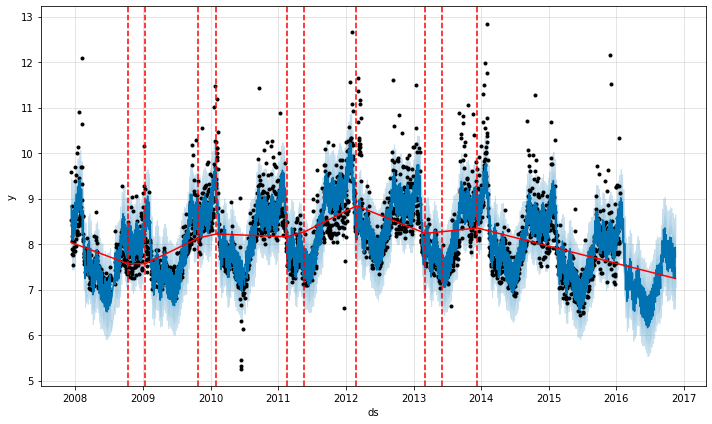

In [16]:
from fbprophet.plot import add_changepoints_to_plot

m = Prophet(changepoint_prior_scale=0.05)
m.fit(df)

future = m.make_future_dataframe(periods=300)
forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),  m, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


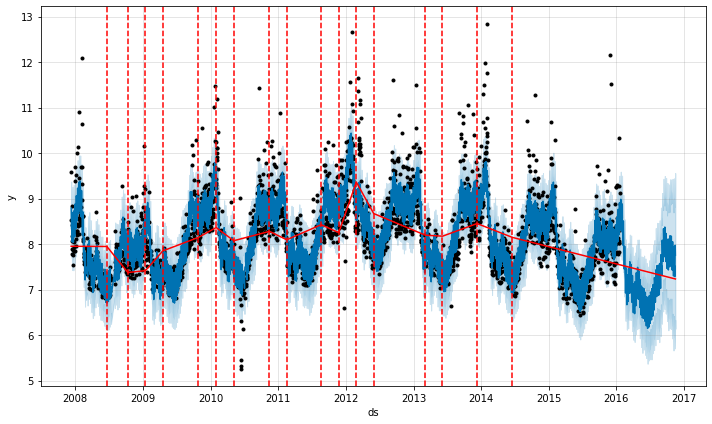

In [17]:
from fbprophet.plot import add_changepoints_to_plot

m = Prophet(changepoint_prior_scale=0.3)
m.fit(df)

future = m.make_future_dataframe(periods=300)
forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),  m, forecast)

changepoint_prior_scale 값을 0.3으로 높여준 후 트렌드를 더 유연하게 감지하는 것을 확인할 수 있습니다. 이 값을 너무 높여버리면 overfitting의 위험이 있으니 주의해야 합니다.

만약 트렌드가 바뀌는 시점(서비스 확대 배포 또는 프로모션 등으로 인한 변화 시점)을 알고 있다면, changepoints 파라미터를 추가할 수 있고, changepoints 수 또한 n_changepoints 로 지정할 수 있습니다. 물론, 이 두 파라미터를 설정해주지 않아도 모델이 자동으로 감지합니다.

# Seasonality

seasonality 관련 파라미터는 다음과 같습니다.

Parameter	|Description
--- | ---
yearly_seasonality	|연 계절성
weekly_seasonality	|주 계절성
daily_seasonality	|일 계절성
seasonality_prior_scale	|계절성 반영 강도
seasonality_mode	|‘additive ‘ 인지 ‘multiplicative’ 인지


prophet 알고리즘은 푸리에급수(Fourier series)를 이용하여 seasonality 패턴을 추정합니다. 푸리에급수는 주기가 있는 함수를 삼각함수의 급수로 나타낸 것인데요, 이 글에서는 자세히 다루지 않겠습니다.

yearly_seasonality, weekly_seasonality 파라미터의 default 값은 ‘10’ 입니다. 만약 이 값을 높이면 어떻게 될까요? 다음에서 yearly_seasonality 값을 20으로 변경해보겠습니다.

yearly_seasonality = 10 (default)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


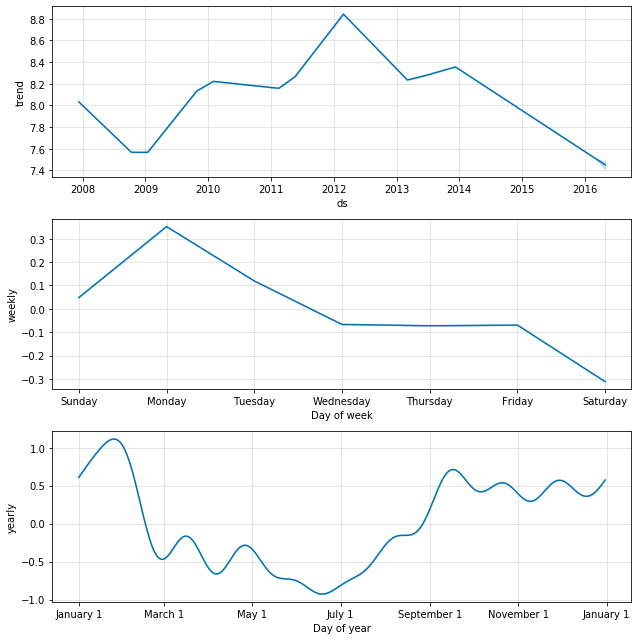

In [21]:
m = Prophet(yearly_seasonality=10)
m.fit(df)

future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

fig = m.plot_components(forecast)

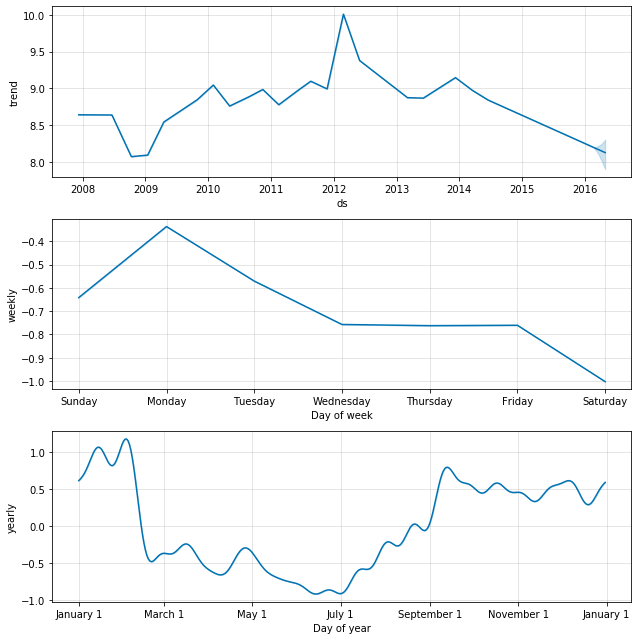

In [37]:
m = Prophet(
    # Trend
    changepoint_prior_scale=0.3
    # Seasonality
    , weekly_seasonality = 10
    , yearly_seasonality = 20
    , daily_seasonality = False
    )
m.fit(df)

future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

fig = m.plot_components(forecast)

yearly_seasonality 값을 20으로 높여준 결과, 연 주기 패턴을 더 유연하게 잡아주는 것을 확인할 수 있습니다. 하지만 너무 유연하게 fitting 된 모델은 overfitting 위험이 높습니다. 값을 낮춰주는 것이 더 적절해 보이네요. 이 파라미터 역시 overfitting 또는, underfitting 되지 않도록 유의해야 합니다.

기본적으로 daily, weely, yearly seasonality에 대해서는 파라미터로 제공되지만, monthly는 제공되지 않습니다. 만약 필요하다면, 임의로 seasonality를 정의하여 모델에 반영할 수 있습니다. 주기가 30.5일이고, fourier order가 5인 ‘monthly’ 라는 이름의 seasonality를 추가해 보겠습니다.

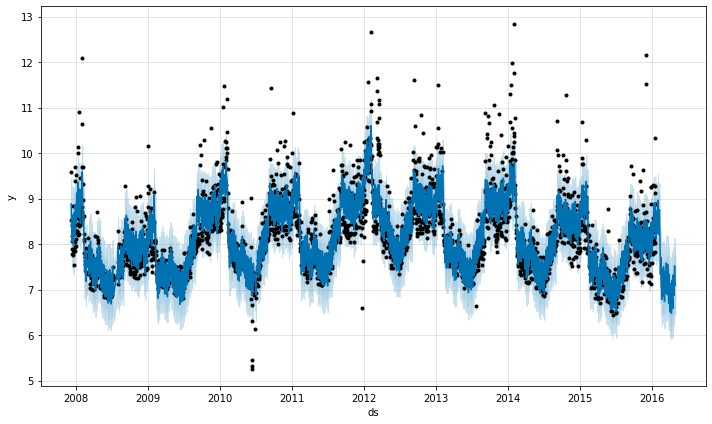

In [40]:
m = Prophet(
    # Trend
    changepoint_prior_scale=0.3
    # Seasonality
    , weekly_seasonality = 10
    , yearly_seasonality = 20
    , daily_seasonality = False
    )
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)

#future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

fig = m.plot(forecast)

동일 기간 예측값을 비교해 봤을 때, 이전보다 monthly seasonality를 더 잘 잡아주는것을 확인할 수 있습니다. 이렇게 필요한 seasonality에 대해서 직접 커스터마이징하여 모델에 추가하는 것이 가능합니다.

추가로 seasonality_mode 파라미터에 대해 소개해 드리겠습니다. 이 파라미터는 시계열 데이터가 Additive인지 Multiplicative인지 명시합니다. 둘의 차이점에 대해서 간단하게 설명드리면, Additive는 데이터의 진폭이 일정함을 의미하고, Multiplicative는 데이터의 진폭이 점점 증가하거나 감소하는 것을 뜻합니다.

만약, 시계열 데이터 분석시 데이터가 Additive인지 Multiplicative인지 잘못 구분한다면 오차항을 제대로 분리하지 못하게 됩니다.

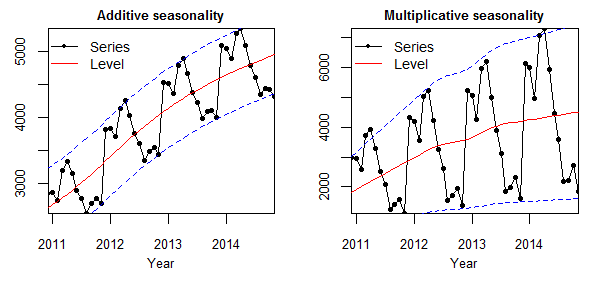

- Additive Seasonality : Time series = Trend + Seasonality + Error
- Multiplicative Seasonality : Time series = Trend * Seasonality * Error

이제 seasonality_mode = 'multiplicative' 파라미터를 모델에 추가해봅시다.

seasonality_mode = ‘additive’ (default)

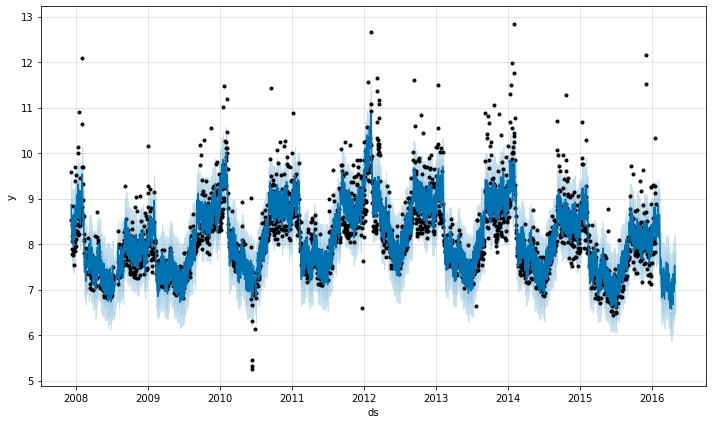

In [41]:
m = Prophet(
    # Trend
    changepoint_prior_scale=0.3
    # Seasonality
    , weekly_seasonality = 10
    , yearly_seasonality = 20
    , daily_seasonality = False
    , seasonality_mode = 'multiplicative'
    )
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)

#future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

fig = m.plot(forecast)

# Holiday

마지막으로 Holiday관련 파라미터입니다.

Parameter	|Description
--- | ---
holidays	|휴일 또는 이벤트 기간을 명시한 데이터프레임
holiday_prior_scale	|holiday 반영 강도


데이터에 영향을 미치는 휴일이나 프로모션같은 이벤트를 알고 있다면, 모델에 반영하여 정확도를 높일 수 있습니다. 우리가 다루고 있는 데이터에서도 수치가 급격하게 상승하는 부분이 있습니다. 휴일이나 명절의 영향으로 수치가 달라질 수 있는데요, 이 특성을 모델에 반영해 보겠습니다.

먼저 holiday 정보 (기간,이름) 을 담은 데이터 프레임을 생성합니다.

m.add_country_holidays(country_name=’국가코드’)로 간단하게 국가 공휴일을 불러올 수도 있습니다. 하지만 모든 국가의 공휴일이 있는건 아닙니다.

In [42]:
holiday = pd.DataFrame({
    'holiday':'holiday'
    , 'ds' : pd.concat([
        pd.Series(pd.date_range('2017-05-05', '2017-06-03', freq='D'))
        , pd.Series(pd.date_range('2018-05-05', '2018-06-03', freq='D'))
        , pd.Series(pd.date_range('2019-05-05', '2019-06-03', freq='D'))
        , pd.Series(pd.date_range('2020-05-05', '2020-06-03', freq='D'))
    ])
})

만약 휴일이 휴일 전,후에도 영향을 미친다면 해당일만큼 파라미터로 설정해 줄 수 있습니다. 예를 들어, 공휴일 영향이 그 다음날에도 영향을 미친다면 lower_window=0, upper_window=1 을 추가하면 됩니다.

위에서 만든 holiday 데이터 프레임을 모델에 holidays 파라미터 값으로 넣어줍니다.

In [58]:
import plotly.graph_objects as go
from fbprophet.plot import plot_plotly


m = Prophet(
    # Trend
    changepoint_prior_scale=0.3
    # Seasonality
    , weekly_seasonality = 10
    , yearly_seasonality = 10
    , daily_seasonality = False
    , seasonality_mode = 'multiplicative'
    # holiday
    , holidays = holiday
    , holidays_prior_scale=15
    )
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(df)

#future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

fig = plot_plotly(m,forecast)
py.iplot(fig)

NameError: name 'go' is not defined

==> pip3 install ipywidgets  
no module named 'plotly' ==> pip3 install plotly

holiday설정 후, 설정해준 기간에 수치가 변화하는 패턴을 더 잘 맞추는 것을 볼 수 있습니다.

이상 Prophet 패키지를 활용한 시계열 데이터 예측이었습니다. 미처 소개시켜드리지 못한 prophet 함수와 기능들이 많지만 글이 길어질 것 같아 여기서 마치겠습니다. 더 자세한 사항은 아래 References로 추가한 페이지들을 참고해주세요.


In [46]:
import fbprophet
print(fbprophet.__version__)

0.6


In [9]:
df['cap'] = 6
df['floor'] = 1.5
df.head()

,ds,y,cap,floor
0,2007-12-10,9.590761,6,1.5
1,2007-12-11,8.519590,6,1.5
2,2007-12-12,8.183677,6,1.5
3,2007-12-13,8.072467,6,1.5
4,2007-12-14,7.893572,6,1.5


In [18]:
# Profit 생성, fit
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
m = Prophet(growth='logistic')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
future = m.make_future_dataframe(periods=365)

future['cap'] = 6
future['floor'] = 1.5

forecast = m.predict(future)
forecast.tail()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,5.999955,6,1.5,4.224372,9.989182,5.999955,5.999955,1.156022,1.156022,...,0.043395,0.043395,0.043395,1.112627,1.112627,1.112627,0.0,0.0,0.0,7.155977
3266,2017-01-16,5.999955,6,1.5,4.565131,10.299281,5.999955,5.999955,1.466360,1.466360,...,0.341568,0.341568,0.341568,1.124792,1.124792,1.124792,0.0,0.0,0.0,7.466316
3267,2017-01-17,5.999955,6,1.5,4.478190,10.088686,5.999955,5.999955,1.261587,1.261587,...,0.125882,0.125882,0.125882,1.135705,1.135705,1.135705,0.0,0.0,0.0,7.261542
3268,2017-01-18,5.999955,6,1.5,4.105008,9.744135,5.999955,5.999955,1.089253,1.089253,...,-0.056002,-0.056002,-0.056002,1.145254,1.145254,1.145254,0.0,0.0,0.0,7.089208
3269,2017-01-19,5.999955,6,1.5,4.289126,10.006864,5.999955,5.999955,1.071552,1.071552,...,-0.081741,-0.081741,-0.081741,1.153293,1.153293,1.153293,0.0,0.0,0.0,7.071508


In [24]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(60)

,ds,yhat,yhat_lower,yhat_upper
3210,2016-11-21,6.778967,3.918028,9.401271
3211,2016-11-22,6.586205,3.834751,9.614628
3212,2016-11-23,6.426644,3.747514,9.282215
3213,2016-11-24,6.422167,3.593934,9.252208
3214,2016-11-25,6.463147,3.617984,9.368944
3215,2016-11-26,6.229078,3.507023,9.035295
3216,2016-11-27,6.600819,3.667178,9.515677
3217,2016-11-28,6.912393,4.239052,9.914100
3218,2016-11-29,6.707551,3.883494,9.687765
3219,2016-11-30,6.533870,3.731369,9.269846


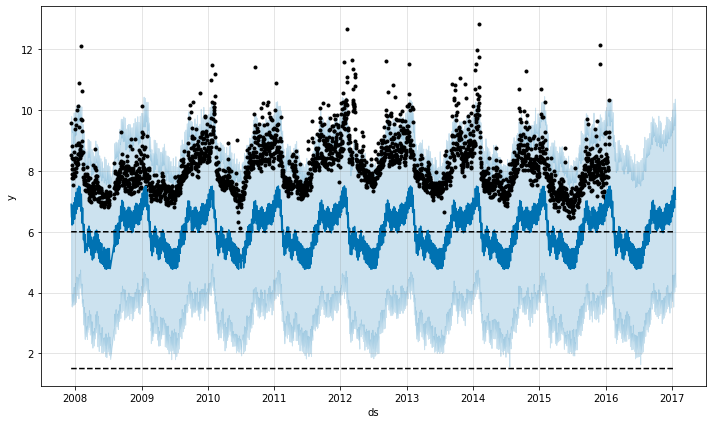

In [22]:
future = m.plot(forecast)

REF:   
https://hyperconnect.github.io/2020/03/09/prophet-package.html
https://gorakgarak.tistory.com/1255